# <img src="https://upload.wikimedia.org/wikipedia/commons/6/60/NISAR_artist_concept.jpg" width=400 align="left"/>
<img src="https://upload.wikimedia.org/wikipedia/commons/9/9b/NISAR_Mission_Logo.png" width=400 align="left"/><br><br><br><br><br>

# NISAR Cal/Val Database - Soil Moisture
## Examples for querying and updating the database

Brandi Downs, October 2024</br>

This notebook demonstrates how to query the NISAR cal/val database using examples for the Soil Moisture schema.

## Import Packages

In [ ]:
import psycopg2
import getpass
import os
import configparser
from psycopg2 import sql
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

## Handling Query Errors

If you run a query that results in an error, you will need to roll the connection back to the start of the transaction to clear the error. 

For example, if I misspell the table name `site_details` as `sitedetails` (in the biomass schema) in the following query, I will get the error below:
```python
query = "SELECT * FROM biomass.site_details;"
```



If I try to correct the spelling and rerun the cell without first running `conn.rollback()`, I will get this error:



I must first run `conn.rollback()`, then I can rerun the cell.

In [ ]:
# # OPTIONAL: If you run a query that results in an error, roll back to the start of the transaction to clear the error
# conn.rollback()


## Connect to the Database

To connect to the database, you need the database connection properties to be stored in a configuration file.</br> 
For this example, the config file is saved in the sds-ondemand folder of our home directory.</br></br>
The configuration file should look like this and be saved in .ini format:

```Python
[DEFAULT] 
dbname=database_name 
host=host_address 
port=port_number 
```

where `database_name`, `host_address`, and `port_number` are parameters that should be specified.


In [ ]:
# Establish a connection to the database

config_file = '~/sds-ondemand/calvaldb_config.ini'

def get_config_data():
    
    file = os.path.expanduser(config_file)

    # Check if the file exists
    if not os.path.exists(file):
        raise FileNotFoundError(f"Configuration file not found: {file}")

    # Parse the configuration file
    config = configparser.ConfigParser()
    try:
        config.read(file)
    except Exception as e:
        raise Exception(f"Configuration file error: {e}")

    # Get connection properties
    conn_properties = config['DEFAULT']
    dbname = conn_properties.get('dbname')
    host = conn_properties.get('host')
    port = conn_properties.get('port')
    if not dbname or not host or not port:
        raise Exception("Missing required properties")
        
    # Get username and password    
    user = input('User name: ')
    password = getpass.getpass('Password: ')
    
    return dbname, host, port, user, password

dbname, host, port, user, password = get_config_data()
conn = psycopg2.connect(dbname=dbname, host=host, port=port, user=user, password=password)    
cur = conn.cursor()


## Explore the Data

The NISAR Cal/Val database contains a separate schema for each of the science sub-disciplines (biomass, inundation, crop_area, disturbance, solidearth, seaice, landice, permafrost, and soil_moisture). 

The schema defines how the data is structured and includes the tables, columns, data types, and relationships between tables. The hierarchical structure is illustrated in the figure below.

**Columns** are also called **Fields** or **Attributes**, and the terms are used interchangeably in this notebook.

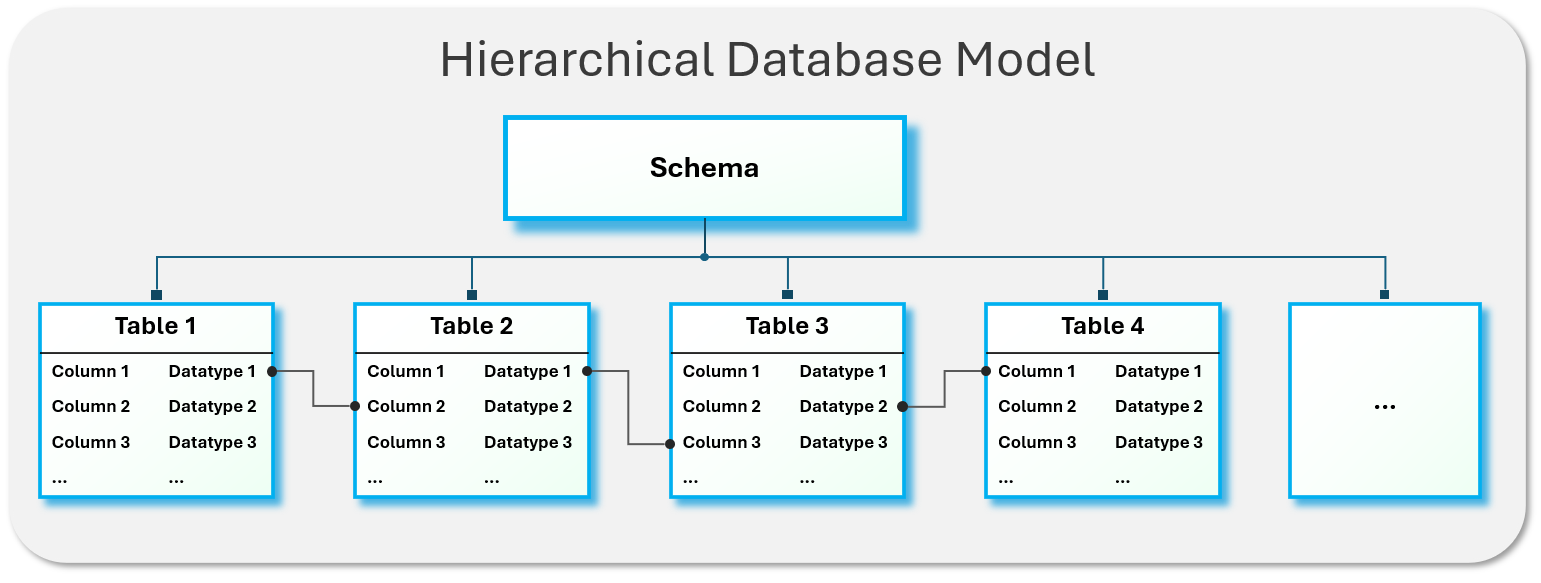

If you are looking for a schema that isn't listed when you run the cell below, and you're sure the schema exists, it's possible you don't have read access to it. In that case, contact Naiara Pinto or Brandi Downs.

### List All Schema in the Database

In [ ]:
# List all schema in the database

query = "SELECT schema_name FROM information_schema.schemata;"
cur.execute(query)
schemas = cur.fetchall()
schemas = [k[0] for k in schemas]
print(*schemas, sep='\n')


### List All Tables for a Specific Schema

In [ ]:
# List all tables for the landice schema

schema_name = 'soil_moisture'

query = "SELECT tablename FROM pg_catalog.pg_tables WHERE schemaname = %(schema_name)s;"
cur.execute(query, {'schema_name': schema_name})
tables = cur.fetchall()
tables = [k[0] for k in tables]
print(*tables, sep='\n')


### List Column Names and Datatypes for a Specific Table

In [ ]:
# List column names and their data types for a specific table

schema_name = 'soil_moisture'
table_name = 'sensor'

query = "SELECT column_name, data_type FROM information_schema.columns WHERE table_schema = %(schema_name)s AND table_name = %(table_name)s;"
cur.execute(query, {'schema_name': schema_name, 'table_name': table_name})
columns = cur.fetchall()
for k in columns:
    print(k[0] + ', ' + k[1])
    

## Get measurements and plot the data

In [ ]:
# Get column names 
schema_name = 'soil_moisture'
table_name = 'measurement'

query = "SELECT column_name, data_type FROM information_schema.columns WHERE table_schema = %(schema_name)s AND table_name = %(table_name)s;"
cur.execute(query, {'schema_name': schema_name, 'table_name': table_name})
columns = cur.fetchall()
for k in columns:
    print(k[0] + ', ' + k[1])
measurement_cols = [k[0] for k in columns]

In [ ]:
# Get sensors from database

# Get column names
schema_name = 'soil_moisture'
table_name = 'sensor'
query = "SELECT column_name FROM information_schema.columns WHERE table_schema = %(schema_name)s AND table_name = %(table_name)s;"
cur.execute(query, {'schema_name': schema_name, 'table_name': table_name})
sensor_cols = cur.fetchall()
sensor_cols = [k[0] for k in sensor_cols]

# Get sensors table in Pandas DataFrame
query = "SELECT * FROM soil_moisture.sensor ORDER BY sensor_id ASC;"
cur.execute(query);
sensors = pd.DataFrame(cur.fetchall(), columns=sensor_cols)
sensors

### Get all measurements for sensor

In [ ]:
d1 = '2024-09-01'
d2 = '2024-09-30'
sensor_id = 1
query = "SELECT * FROM soil_moisture.measurement WHERE sensor_id = %(sensor_id)s AND datetime_utc BETWEEN %(d1)s AND %(d2)s ORDER BY measurement_id;"
cur.execute(query, {'d1': d1, 'd2': d2, 'sensor_id': sensor_id})
M = pd.DataFrame(cur.fetchall(), columns=measurement_cols)
M

### Plot measurements

In [ ]:
# Plot soil moisture %

ylabel_str = 'Soil Moisture (%)'
M.plot(x='datetime_utc', y='soil_moisture_pct', kind='line', ylabel=ylabel_str, xlabel='Date')
plt.grid(True)

In [ ]:
# Plot soil temperature

ylabel_str = 'Soil Temperature (C)'
M.plot(x='datetime_utc', y='soil_temperature_c', kind='line', ylabel=ylabel_str, xlabel='Date')
plt.grid(True)

## Plot sensors on map

In [ ]:
sensors

In [ ]:
color_scale = [(0, 'orange'), (1,'red')]
fig = px.scatter_mapbox(sensors, 
                        lat="latitude", 
                        lon="longitude", 
                        hover_name="dev_eui", 
                        hover_data=["manufacturer","model","install_date"],
                        #color='sensor_type', #"Listed",
                        #color_continuous_scale=color_scale,
                        #size=10, #"Listed",
                        zoom=6, 
                        height=600,
                        width=900,
                        mapbox_style="open-street-map")

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_traces(marker=dict(size=12, color='red'))
fig.show()

In [ ]:
#conn.rollback()

<a id="SEC_2"></a>
## 2 &emsp; Close the Connection to the Database

Please make sure to run the cell below and properly close the cursor object and disconnect from the database.

In [ ]:
# Close the cursor and connection

cur.close()
conn.close()
